In [1]:
import sys
import os
import json
import glob
import h5py

import numpy as np
import scipy.signal
import scipy.io.wavfile
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import IPython.display as ipd

import importlib

sys.path.append('/om2/user/msaddler/python-packages/bez2018model')
import bez2018model
importlib.reload(bez2018model)

sys.path.append('assets_psychophysics')
import util_figures
importlib.reload(util_figures)
import util_figures_stimuli
importlib.reload(util_figures_stimuli)

sys.path.append('assets_datasets')
import stimuli_util
importlib.reload(stimuli_util)


<module 'stimuli_util' from 'assets_datasets/stimuli_util.py'>

In [2]:
kwargs_nervegram_meanrates = {
    'meanrates_params': {
        'dur': 0.050,
        'fs':20e3,
        'buffer_start_dur': 0.07,
        'buffer_end_dur': 0.01,
    },
    'ANmodel_params': {
        'num_cfs': 100,
        'min_cf':125,
        'max_cf':14e3,
        'spont_list':[70.0],
        'cohc':1.0,
        'bandwidth_scale_factor':1.0,
        'IhcLowPass_cutoff': 3000.0,
        'IhcLowPass_order': 7,
    },
}


sr = 32000
t = np.arange(0, 0.150, 1/sr)
signal = np.zeros_like(t)
noise = np.random.randn(signal.shape[0])
f0 = 200
phase_mode = 'sine'
spectral_region = 'none'

freq_list = f0*np.arange(1, 60)

if phase_mode == 'alt':
    phase_list = np.pi/2 * np.ones(len(freq_list))
    phase_list[::2] = 0
else:
    phase_list = np.zeros(len(freq_list))

for freq, phase in zip(freq_list, phase_list):
    if freq < sr/2:
        signal = signal + np.sin(2*np.pi*freq*t + phase)

snr = 12
dBSPL = 60
noise = np.random.randn(noise.shape[0])

y = stimuli_util.combine_signal_and_noise(signal, noise, snr=snr,
                                          rms_out=20e-6*np.power(10, dBSPL/20))
ipd.display(ipd.Audio(y, rate=sr))

out_dict = bez2018model.nervegram_meanrates(y, sr, **kwargs_nervegram_meanrates)



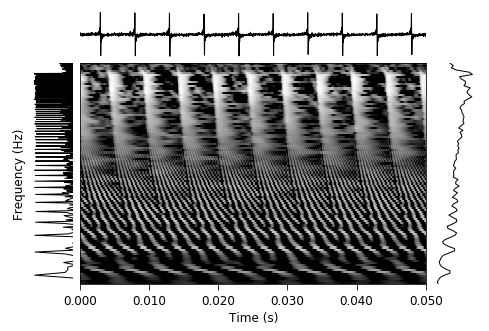

In [48]:
import util_figures
importlib.reload(util_figures)
import util_figures_stimuli
importlib.reload(util_figures_stimuli)


def figure_wrapper_nervegram_stimulus(ax_arr,
                                      ax_idx_nervegram=1,
                                      ax_idx_power_spectrum=0,
                                      ax_idx_excitation_pattern=2,
                                      ax_idx_waveform=None,
                                      nervegram=None,
                                      nervegram_sr=None,
                                      waveform=None,
                                      waveform_sr=None,
                                      cfs=[],
                                      tmin=None,
                                      tmax=None,
                                      treset=True,
                                      fontsize_title=12,
                                      fontsize_labels=12,
                                      fontsize_legend=12,
                                      fontsize_ticks=12,
                                      fontweight_labels=None,
                                      spines_to_hide=['top', 'bottom', 'left', 'right'],
                                      plot_kwargs={},
                                      xlimits_buffer=0.1,
                                      ax_arr_clear_leftover=True):
    '''
    '''
    # KEEP TRACK OF AXES IN 1D ARRAY
    ax_arr = np.array([ax_arr]).reshape([-1])
    assert len(ax_arr.shape) == 1
    ax_idx_list = []
    # PLOT AUDITORY NERVEGRAM
    if ax_idx_nervegram is not None:
        ax_idx_list.append(ax_idx_nervegram)
        util_figures_stimuli.make_nervegram_plot(ax_arr[ax_idx_nervegram],
                                                 nervegram,
                                                 sr=nervegram_sr,
                                                 cfs=cfs,
                                                 fontsize_title=fontsize_title,
                                                 fontsize_labels=fontsize_labels,
                                                 fontsize_legend=fontsize_legend,
                                                 fontsize_ticks=fontsize_ticks,
                                                 fontweight_labels=fontweight_labels,
                                                 nxticks=6,
                                                 nyticks=0,
                                                 tmin=tmin,
                                                 tmax=tmax,
                                                 treset=treset,
                                                 str_title=None,
                                                 str_xlabel='Time (s)',
                                                 str_ylabel=None,
                                                 str_clabel=None)
    # PLOT POWER SPECTRUM
    if ax_idx_power_spectrum is not None:
        ax_idx_list.append(ax_idx_power_spectrum)
        fxx, pxx = stimuli_util.power_spectrum(out_dict['pin'], out_dict['pin_fs'])
        IDX = np.logical_and(fxx >= np.min(cfs), fxx <= np.max(cfs))
        x_pxx = pxx[IDX]
        y_pxx = stimuli_util.freq2erb(fxx[IDX])
        xlimits_buffer_pxx = xlimits_buffer * np.max(x_pxx)
        ylimits_pxx = [np.min(y_pxx), np.max(y_pxx)]
        xlimits_pxx = [np.max(x_pxx) + xlimits_buffer_pxx, np.min(x_pxx) - xlimits_buffer_pxx]
        xlimits_pxx[-1] = 0
        util_figures_stimuli.make_line_plot(ax_arr[ax_idx_power_spectrum], x_pxx, y_pxx,
                                            plot_kwargs=plot_kwargs,
                                            fontsize_title=fontsize_title,
                                            fontsize_labels=fontsize_labels,
                                            fontsize_legend=fontsize_legend,
                                            fontsize_ticks=fontsize_ticks,
                                            fontweight_labels=None,
                                            str_title=None,
                                            str_xlabel=None,
                                            str_ylabel='Frequency (Hz)',
                                            xlimits=xlimits_pxx,
                                            ylimits=ylimits_pxx,
                                            xticks=[],
                                            xticklabels=[],
                                            yticks=[],
                                            yticklabels=[],
                                            legend_on=False,
                                            legend_kwargs={},
                                            spines_to_hide=spines_to_hide)
    # PLOT EXCITATION PATTERN
    if ax_idx_excitation_pattern is not None:
        ax_idx_list.append(ax_idx_excitation_pattern)
        x_exc = np.mean(nervegram, axis=1)
        y_exc = np.arange(0, nervegram.shape[0])
        xlimits_exc_buffer = xlimits_buffer * np.max(x_exc)
        xlimits_exc = [np.min(x_exc) - xlimits_exc_buffer, np.max(x_exc) + xlimits_exc_buffer]
        ylimits_exc = [np.min(y_exc), np.max(y_exc)]
        util_figures_stimuli.make_line_plot(ax_arr[ax_idx_excitation_pattern], x_exc, y_exc,
                                            plot_kwargs=plot_kwargs,
                                            fontsize_title=fontsize_title,
                                            fontsize_labels=fontsize_labels,
                                            fontsize_legend=fontsize_legend,
                                            fontsize_ticks=fontsize_ticks,
                                            fontweight_labels=fontweight_labels,
                                            str_title=None,
                                            str_xlabel=None,
                                            str_ylabel=None,
                                            xlimits=xlimits_exc,
                                            ylimits=ylimits_exc,
                                            xticks=[],
                                            xticklabels=[],
                                            yticks=[],
                                            yticklabels=[],
                                            legend_on=False,
                                            legend_kwargs={},
                                            spines_to_hide=spines_to_hide)
    # PLOT WAVEFORM
    if ax_idx_waveform is not None:
        ax_idx_list.append(ax_idx_waveform)
        y_wav = np.squeeze(waveform)
        assert len(y_wav.shape) == 1, "waveform must be 1D array"
        x_wav = np.arange(0, y_wav.shape[0]) / waveform_sr
        if (tmin is not None) and (tmax is not None):
            IDX = np.logical_and(x_wav >= tmin, x_wav < tmax)
            x_wav = x_wav[IDX]
            y_wav = y_wav[IDX]
        if treset:
            x_wav = x_wav - x_wav[0]
        xlimits_wav = [x_wav[0], x_wav[-1]]
        ylimits_wav = [np.max(np.abs(y_wav)), -np.max(np.abs(y_wav))]
        util_figures_stimuli.make_line_plot(ax_arr[ax_idx_waveform], x_wav, y_wav,
                                            plot_kwargs=plot_kwargs,
                                            fontsize_title=fontsize_title,
                                            fontsize_labels=fontsize_labels,
                                            fontsize_legend=fontsize_legend,
                                            fontsize_ticks=fontsize_ticks,
                                            fontweight_labels=fontweight_labels,
                                            str_title=None,
                                            str_xlabel=None,
                                            str_ylabel=None,
                                            xlimits=xlimits_wav,
                                            ylimits=ylimits_wav,
                                            xticks=[],
                                            xticklabels=[],
                                            yticks=[],
                                            yticklabels=[],
                                            legend_on=False,
                                            legend_kwargs={},
                                            spines_to_hide=['top', 'bottom', 'left', 'right'])
    # CLEAR UNUSED AXES
    if ax_arr_clear_leftover:
        for ax_idx in range(ax_arr.shape[0]):
            if ax_idx not in ax_idx_list:
                ax_arr[ax_idx].axis('off')
    return ax_arr


figsize=(8, 5)
nrows=2
ncols=3
gridspec_kw = {
    'wspace': 0.05,
    'hspace': 0.05,
    'width_ratios': [1, 8, 1],
    'height_ratios': [1, 5],
}
fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw=gridspec_kw)
# ax_arr = ax_arr.reshape([-1])

figure_wrapper_nervegram_stimulus(ax_arr,
                                  ax_idx_nervegram=4,
                                  ax_idx_power_spectrum=3,
                                  ax_idx_excitation_pattern=5,
                                  ax_idx_waveform=1,
                                  nervegram=out_dict['meanrates'],
                                  nervegram_sr=out_dict['meanrates_fs'],
                                  waveform=out_dict['pin'],
                                  waveform_sr=out_dict['pin_fs'],
                                  cfs=out_dict['cf_list'],
                                  fontsize_title=12,
                                  fontsize_labels=12,
                                  fontsize_legend=12,
                                  fontsize_ticks=12,
                                  fontweight_labels=None,
                                  spines_to_hide=['top', 'bottom', 'left', 'right'],
                                  plot_kwargs={},
                                  xlimits_buffer=0.1)

plt.show()



In [7]:
# np.min(x_exc)
out_dict['pin'].shape

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
# ax = util_figures_stimuli.make_waveform_plot(ax,
#                                              out_dict['pin'],
#                                              sr=out_dict['pin_fs'],
#                                              fontsize_labels=12,
#                                              fontsize_ticks=10,
#                                              lw=4.0,
#                                              tmin=None,
#                                              tmax=None,
#                                              treset=True)


(5000,)

In [44]:
ax_arr.shape

(2, 3)